<a href="https://colab.research.google.com/github/MaxwellMensah/TORCHVISION/blob/pytorch_torchvision/main/_generated_ipynb_notebooks/plot_transforms_getting_started.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Getting started with transforms v2

<div class="alert alert-info"><h4>Note</h4><p>Try on [Colab](https://colab.research.google.com/github/pytorch/vision/blob/gh-pages/main/_generated_ipynb_notebooks/plot_transforms_getting_started.ipynb)
    or `go to the end <sphx_glr_download_auto_examples_transforms_plot_transforms_getting_started.py>` to download the full example code.</p></div>

This example illustrates all of what you need to know to get started with the
new :mod:`torchvision.transforms.v2` API. We'll cover simple tasks like
image classification, and more advanced ones like object detection /
segmentation.


First, a bit of setup



In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision.transforms.v2.functional as F

def plot(imgs, row_title=None, **imshow_kwargs):
    """Display images or (image, bounding boxes) pairs."""
    if not isinstance(imgs, list):
        imgs = [imgs]

    num_imgs = len(imgs)
    fig, axs = plt.subplots(1, num_imgs, figsize=(6 * num_imgs, 6))
    if num_imgs == 1:
        axs = [axs]

    for i, item in enumerate(imgs):
        ax = axs[i]

        if isinstance(item, tuple):
            img, boxes = item
        else:
            img, boxes = item, None

        if isinstance(img, torch.Tensor) and img.ndim == 3 and img.shape[0] in (1, 3):
            img = img.detach().permute(1, 2, 0)  # C x H x W → H x W x C

        ax.imshow(img, **imshow_kwargs)
        ax.axis('off')
        if boxes is not None:
            # Draw boxes using torchvision's built-in utility
            for box in boxes.to('cpu'):
                x0, y0, x1, y1 = box.tolist()
                rect = plt.Rectangle((x0, y0), x1 - x0, y1 - y0, fill=False, edgecolor='red', linewidth=2)
                ax.add_patch(rect)

        if row_title:
            ax.set_title(row_title[i] if isinstance(row_title, list) else row_title)

    plt.tight_layout()
    plt.show()

In [2]:
from pathlib import Path
import torch
import matplotlib.pyplot as plt
plt.rcParams["savefig.bbox"] = 'tight'

from torchvision.transforms import v2
from torchvision.io import decode_image

torch.manual_seed(1)

# If you're trying to run that on Colab, you can download the assets and the
# # helpers from https://github.com/pytorch/vision/tree/main/gallery/
# from helpers import plot --- not working, had the create a custom function to set plot.
img = decode_image(str(Path('./assets') / 'astronaut.jpg'))
print(f"{type(img) = }, {img.dtype = }, {img.shape = }")

type(img) = <class 'torch.Tensor'>, img.dtype = torch.uint8, img.shape = torch.Size([3, 1200, 960])


## The basics

The Torchvision transforms behave like a regular :class:`torch.nn.Module` (in
fact, most of them are): instantiate a transform, pass an input, get a
transformed output:



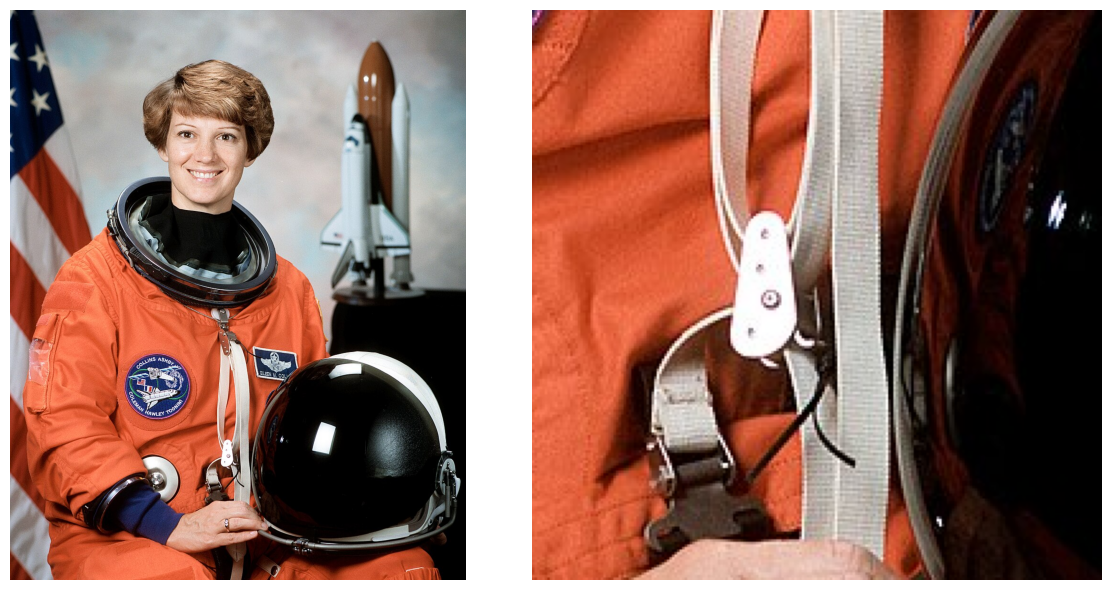

In [3]:
transform = v2.RandomCrop(size=(224, 224))
out = transform(img)

plot([img, out])

## I just want to do image classification

If you just care about image classification, things are very simple. A basic
classification pipeline may look like this:



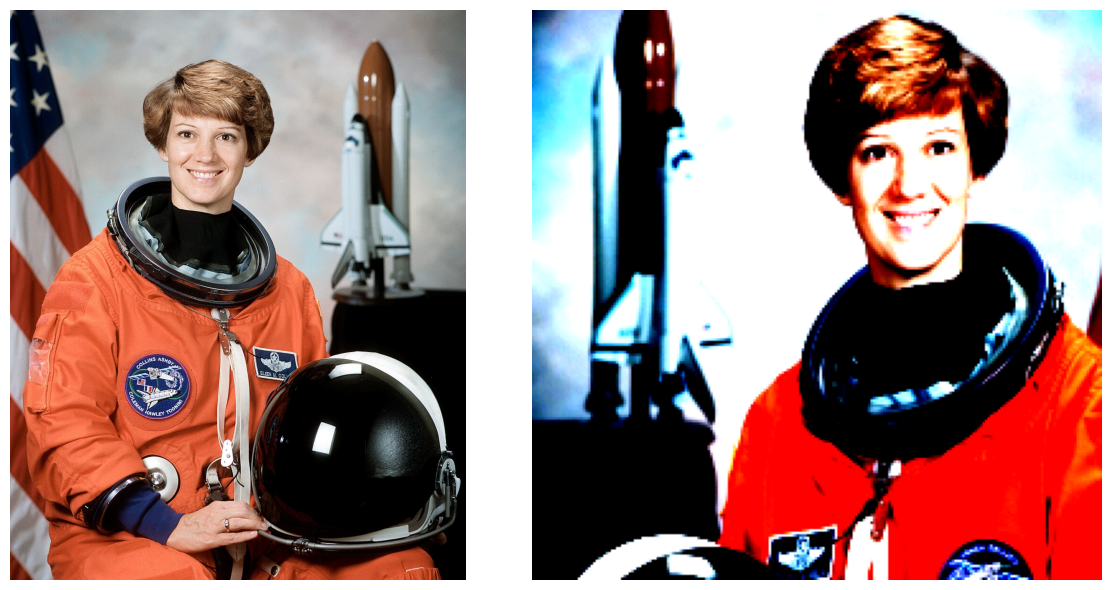

In [4]:
transforms = v2.Compose([
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
out = transforms(img)

plot([img, out])

Such transformation pipeline is typically passed as the ``transform`` argument
to the `Datasets <datasets>`, e.g. ``ImageNet(...,
transform=transforms)``.

That's pretty much all there is. From there, read through our `main docs
<transforms>` to learn more about recommended practices and conventions, or
explore more `examples <transforms_gallery>` e.g. how to use augmentation
transforms like `CutMix and MixUp
<sphx_glr_auto_examples_transforms_plot_cutmix_mixup.py>`.

<div class="alert alert-info"><h4>Note</h4><p>If you're already relying on the ``torchvision.transforms`` v1 API,
    we recommend to `switch to the new v2 transforms<v1_or_v2>`. It's
    very easy: the v2 transforms are fully compatible with the v1 API, so you
    only need to change the import!</p></div>

## Detection, Segmentation, Videos

The new Torchvision transforms in the ``torchvision.transforms.v2`` namespace
support tasks beyond image classification: they can also transform bounding
boxes, segmentation / detection masks, or videos.

Let's briefly look at a detection example with bounding boxes.



<class 'torchvision.tv_tensors._bounding_boxes.BoundingBoxes'> <class 'torchvision.tv_tensors._bounding_boxes.BoundingBoxes'>


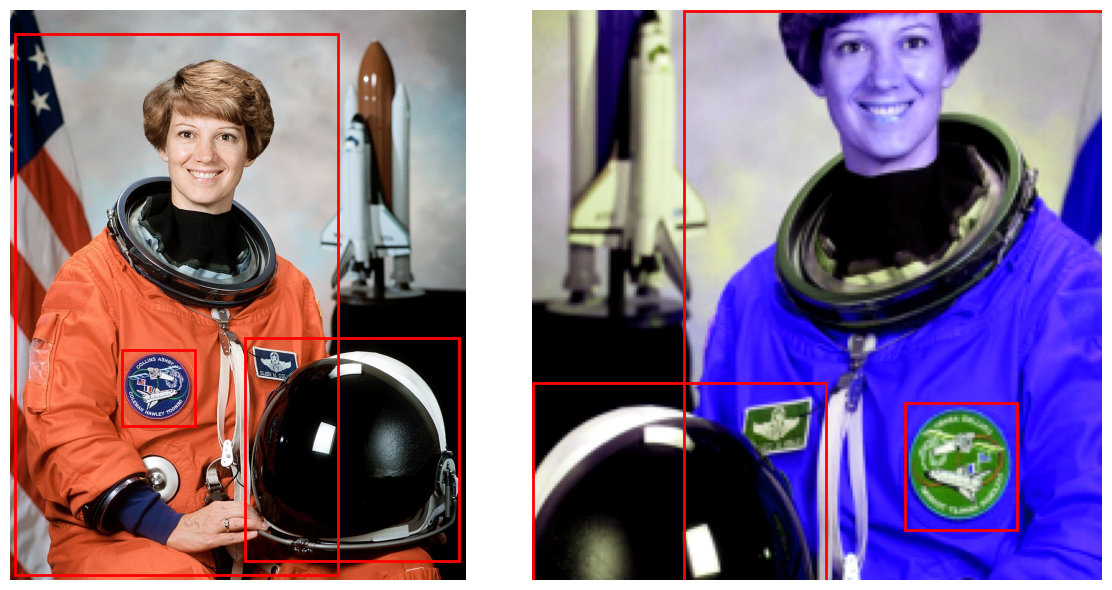

In [5]:
from torchvision import tv_tensors  # we'll describe this a bit later, bare with us

boxes = tv_tensors.BoundingBoxes(
    [
        [10, 50, 690, 1190],
        [945, 690, 495, 1160],
        [235, 716, 390, 875]
    ],
    format="XYXY", canvas_size=img.shape[-2:])

transforms = v2.Compose([
    v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomPhotometricDistort(p=1),
    v2.RandomHorizontalFlip(p=1),
])
out_img, out_boxes = transforms(img, boxes)
print(type(boxes), type(out_boxes))

plot([(img, boxes), (out_img, out_boxes)])

The example above focuses on object detection. But if we had masks
(:class:`torchvision.tv_tensors.Mask`) for object segmentation or semantic
segmentation, or videos (:class:`torchvision.tv_tensors.Video`), we could have
passed them to the transforms in exactly the same way.

By now you likely have a few questions: what are these TVTensors, how do we
use them, and what is the expected input/output of those transforms? We'll
answer these in the next sections.




## What are TVTensors?

TVTensors are :class:`torch.Tensor` subclasses. The available TVTensors are
:class:`~torchvision.tv_tensors.Image`,
:class:`~torchvision.tv_tensors.BoundingBoxes`,
:class:`~torchvision.tv_tensors.Mask`, and
:class:`~torchvision.tv_tensors.Video`.

TVTensors look and feel just like regular tensors - they **are** tensors.
Everything that is supported on a plain :class:`torch.Tensor` like ``.sum()``
or any ``torch.*`` operator will also work on a TVTensor:



In [6]:
img_dp = tv_tensors.Image(torch.randint(0, 256, (3, 256, 256), dtype=torch.uint8))

print(f"{isinstance(img_dp, torch.Tensor) = }")
print(f"{img_dp.dtype = }, {img_dp.shape = }, {img_dp.sum() = }")

isinstance(img_dp, torch.Tensor) = True
img_dp.dtype = torch.uint8, img_dp.shape = torch.Size([3, 256, 256]), img_dp.sum() = tensor(25087893)


These TVTensor classes are at the core of the transforms: in order to
transform a given input, the transforms first look at the **class** of the
object, and dispatch to the appropriate implementation accordingly.

You don't need to know much more about TVTensors at this point, but advanced
users who want to learn more can refer to
`sphx_glr_auto_examples_transforms_plot_tv_tensors.py`.

## What do I pass as input?

Above, we've seen two examples: one where we passed a single image as input
i.e. ``out = transforms(img)``, and one where we passed both an image and
bounding boxes, i.e. ``out_img, out_boxes = transforms(img, boxes)``.

In fact, transforms support **arbitrary input structures**. The input can be a
single image, a tuple, an arbitrarily nested dictionary... pretty much
anything. The same structure will be returned as output. Below, we use the
same detection transforms, but pass a tuple (image, target_dict) as input and
we're getting the same structure as output:



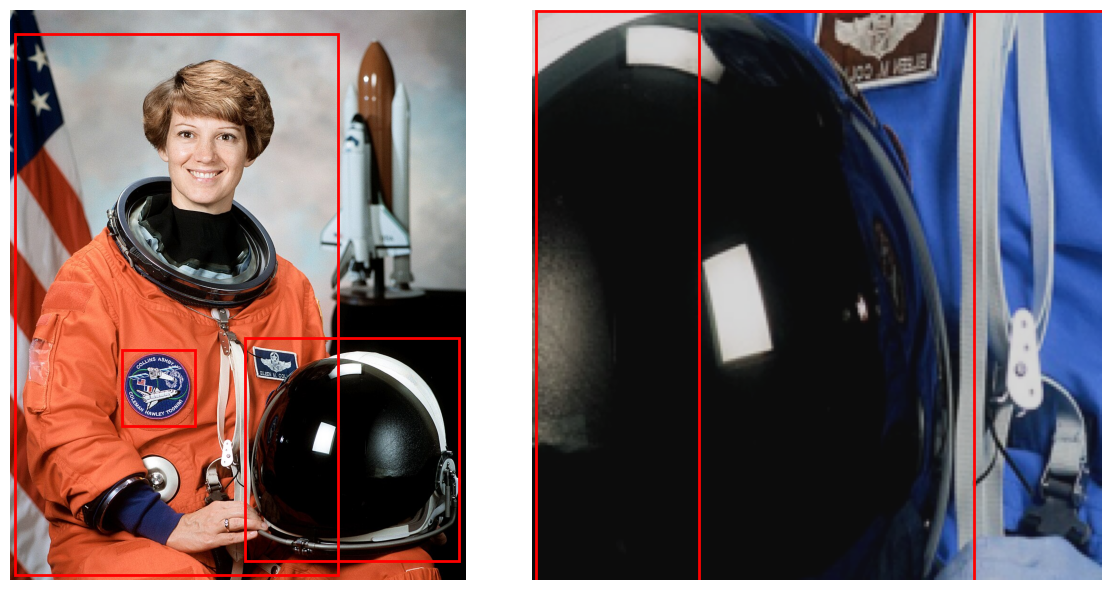

('arbitrary', {'structure': '!'})


In [7]:
target = {
    "boxes": boxes,
    "labels": torch.arange(boxes.shape[0]),
    "this_is_ignored": ("arbitrary", {"structure": "!"})
}

# Re-using the transforms and definitions from above.
out_img, out_target = transforms(img, target)

plot([(img, target["boxes"]), (out_img, out_target["boxes"])])
print(f"{out_target['this_is_ignored']}")

We passed a tuple so we get a tuple back, and the second element is the
tranformed target dict. Transforms don't really care about the structure of
the input; as mentioned above, they only care about the **type** of the
objects and transforms them accordingly.

*Foreign* objects like strings or ints are simply passed-through. This can be
useful e.g. if you want to associate a path with every single sample when
debugging!


<div class="alert alert-info"><h4>Note</h4><p>**Disclaimer** This note is slightly advanced and can be safely skipped on
    a first read.

    Pure :class:`torch.Tensor` objects are, in general, treated as images (or
    as videos for video-specific transforms). Indeed, you may have noticed
    that in the code above we haven't used the
    :class:`~torchvision.tv_tensors.Image` class at all, and yet our images
    got transformed properly. Transforms follow the following logic to
    determine whether a pure Tensor should be treated as an image (or video),
    or just ignored:

    * If there is an :class:`~torchvision.tv_tensors.Image`,
      :class:`~torchvision.tv_tensors.Video`,
      or :class:`PIL.Image.Image` instance in the input, all other pure
      tensors are passed-through.
    * If there is no :class:`~torchvision.tv_tensors.Image` or
      :class:`~torchvision.tv_tensors.Video` instance, only the first pure
      :class:`torch.Tensor` will be transformed as image or video, while all
      others will be passed-through. Here "first" means "first in a depth-wise
      traversal".

    This is what happened in the detection example above: the first pure
    tensor was the image so it got transformed properly, and all other pure
    tensor instances like the ``labels`` were passed-through (although labels
    can still be transformed by some transforms like
    :class:`~torchvision.transforms.v2.SanitizeBoundingBoxes`!).</p></div>


## Transforms and Datasets intercompatibility

Roughly speaking, the output of the datasets must correspond to the input of
the transforms. How to do that depends on whether you're using the torchvision
`built-in datatsets <datasets>`, or your own custom datasets.

### Using built-in datasets

If you're just doing image classification, you don't need to do anything. Just
use ``transform`` argument of the dataset e.g. ``ImageNet(...,
transform=transforms)`` and you're good to go.

Torchvision also supports datasets for object detection or segmentation like
:class:`torchvision.datasets.CocoDetection`. Those datasets predate
the existence of the :mod:`torchvision.transforms.v2` module and of the
TVTensors, so they don't return TVTensors out of the box.

An easy way to force those datasets to return TVTensors and to make them
compatible with v2 transforms is to use the
:func:`torchvision.datasets.wrap_dataset_for_transforms_v2` function:

```python
from torchvision.datasets import CocoDetection, wrap_dataset_for_transforms_v2

dataset = CocoDetection(..., transforms=my_transforms)
dataset = wrap_dataset_for_transforms_v2(dataset)
# Now the dataset returns TVTensors!
```
### Using your own datasets

If you have a custom dataset, then you'll need to convert your objects into
the appropriate TVTensor classes. Creating TVTensor instances is very easy,
refer to `tv_tensor_creation` for more details.

There are two main places where you can implement that conversion logic:

- At the end of the datasets's ``__getitem__`` method, before returning the
  sample (or by sub-classing the dataset).
- As the very first step of your transforms pipeline

Either way, the logic will depend on your specific dataset.

